In [1]:
import argparse
from vit_baseline import ViT_LoRA
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor
from utils import Logger
import os, sys
import torch
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

/home/users/akane/miniconda3/envs/nattome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.argv=['']
parser = argparse.ArgumentParser()

parser.add_argument("-d", "--data", type=str, default="oxfordpets")
parser.add_argument("-ddir", "--data-dir", type=str, default="../data")
parser.add_argument("-odir", "--output-dir", type=str, default="./output")
parser.add_argument("-bs", "--batch_size", type=int, default=32)
parser.add_argument("-p", "--patience", type=int, default=10)
parser.add_argument("-nw", "--num_workers", type=int, default=2)
parser.add_argument("-nc", "--num_classes", type=int, default=None)
parser.add_argument("-e", "--epochs", type=int, default=50)
parser.add_argument("-lr", "--lr", type=float, default=5e-6)
parser.add_argument("-wd", "--weight-decay", type=float, default=1e-6)
parser.add_argument("--device", type=str, default="cuda:0")

parser.add_argument("-lora", "--use-lora", type=bool, default=False)

parser.add_argument(
    "--lora-r",
    type=int,
    default=16,
    help="The dimension used by the LoRA update matrices",
)
parser.add_argument("--lora-alpha", type=int, default=16, help="scaling factor")
parser.add_argument("--lora-dropout", type=float, default=0.1)
parser.add_argument(
    "--lora-bias",
    type=str,
    default="none",
    help="if bias params should be trained or not",
)

args = parser.parse_args()
args.num_classes = 37

In [3]:
# # for i in range(100, 150):
# impath = f"/workspace/akane/data/oxford-iiit-pet/images/great_pyrenees_1.jpg"
# print(impath)
# im = Image.open(impath)
# display(im)

In [4]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

tr=transforms.Compose(
            [
                transforms.Resize(processor.size["height"]),
                transforms.CenterCrop(processor.size["height"]),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=processor.image_mean, std=processor.image_std
                ),
            ]
        )

In [27]:
def load_dataset():
    test_ds = datasets.OxfordIIITPet(
        root=args.data_dir,
        split="test",
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(processor.size["height"]),
                transforms.CenterCrop(processor.size["height"]),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=processor.image_mean, std=processor.image_std
                ),
            ]
        ),
    )
    test_loader = DataLoader(
        test_ds, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers
    )
    return test_loader

def load_model(savepath, lora=False):
    model = ViT_LoRA(args, use_LoRA=lora)
    
    model.load_state_dict(torch.load(savepath))
    model.eval()
    return model

def load_and_trf_im(impath):
    im = Image.open(impath)
    pre_im = tr(im).unsqueeze(0)
    return pre_im

def model_call(model, impath):
    pre_im = load_and_trf_im(impath)
    outs = model(pre_im.to("cuda:0"), return_all=True)
    model_artifacts = outs[2]
    model_predictions = outs[1]
    model_inputs = outs[0]
    return model_artifacts, model_predictions, model_inputs

def model_call_dl(model, dl):
    outs = list()
    labels = list()
    for batch in dl:
        ims = batch[0].to("cuda:0")
        feats = model(ims, return_all=True)[-1].pooler_output
        outs.append(feats)
        labels.append(batch[1])
    outs = torch.concat(outs, dim=0)
    labels = torch.concat(labels, dim=0)
    return outs, labels
        


In [182]:

def get_attention_map(att_mat, get_mask=False):
    # logits, att_mat = model(x.unsqueeze(0))
    att_mat = torch.stack(att_mat).squeeze(1).cpu()

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), (224, 224))[..., np.newaxis]
        # result = (mask * img).astype("uint8")
    
    return mask

def save_image(data, filename):
    fig = plt.figure(figsize=(1, 1))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap="hot")
    fig.savefig(filename, dpi=data.shape[0]) 
    plt.close(fig)


def save_attention_maps(savedir, all_layer_attentions, prefix="attn_maps_"):
    if all_layer_attentions[0].shape[0] > 1:
        raise ValueError("Got multiple images in one")
    for layer_idx, attnmap in enumerate(all_layer_attentions):
        print(attnmap.shape)
        attnmap = attnmap[0].mean(0)
        save_image(attnmap.detach().cpu().numpy(), os.path.join(savedir, prefix) + "layer" + str(layer_idx) + ".jpg")
        # plt.imshow(attnmap.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
        # plt.plot()
        # plt.savefig(os.path.join(savedir, prefix) + "layer" + str(layer_idx) + ".jpg")
    

def save_attention_maps_intensity_distr(savedir, attnmap1, attnmap2, prefix="attn_maps_"):
    # if all_layer_attentions[0].shape[0] > 1:
    #     raise ValueError("Got multiple images in one")
    # for layer_idx, attnmap in enumerate(all_layer_attentions):
        # print(attnmap.shape)
    # attnmap = attnmap[0].mean(0).detach().cpu().numpy()
    # print(attnmap.shape)
    flattened1 = np.reshape(attnmap1, (-1,))
    flattened2 = np.reshape(attnmap2, (-1,))
    # print(flattened)
    
    # n, x, _ = plt.hist(flattened,  density=True)
    # plt.ylim(0, 2500)
    plt.hist(flattened1, label="Vanilla", bins=np.linspace(0, 1, 200), histtype=u'step', density=True)
    plt.hist(flattened2, label="LoRA",bins=np.linspace(0, 1, 200), histtype=u'step', density=True)
    # from matplotlib.ticker import PercentFormatter

    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.xlabel("Attention values")
    plt.ylabel("Percentage")
    plt.title("Histogram of attention intensities")

    # plt.plot(x)
    # plt.show()
    # save_image(attnmap.detach().cpu().numpy(), os.path.join(savedir, prefix) + "layer" + str(layer_idx) + ".jpg")
    # plt.imshow(attnmap.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    # plt.plot()plt.legend(bbox_to_anchor = (1.0, 1), loc = 'best') 
    plt.legend(bbox_to_anchor = (1.0, 1), loc = 'best') 

    plt.savefig(os.path.join(savedir, prefix) + "hist.jpg")
    plt.clf()
    


In [186]:

# model = load_model("/workspace/akane/TA_for_CL/output/vit_task_oxfordpets_baseline_lora.pt", lora=True)
# no = ""
no = ""
model_lora = load_model(f"/workspace/akane/TA_for_CL/output/vit_task_oxfordpets_baseline_{no}lora.pt", lora=no=="")
# model_lora = load_model(f"/workspace/akane/TA_for_CL/output/vit_task_oxfordpets_baseline_{no}lora.pt", lora=no=="")
model_lora_artifacts, model_lora_predictions, model_lora_inputs = model_call(model_lora, "/workspace/akane/data/oxford-iiit-pet/images/great_pyrenees_128.jpg")


no = "no"
model_nolora = load_model(f"/workspace/akane/TA_for_CL/output/vit_task_oxfordpets_baseline_{no}lora.pt", lora=no=="")
model_nolora_artifacts, model_nolora_predictions, model_nolora_inputs = model_call(model_nolora, "/workspace/akane/data/oxford-iiit-pet/images/great_pyrenees_128.jpg")

result2 = get_attention_map(model_lora_artifacts.attentions, get_mask=False)
# del model, model_artifacts, model_predictions, model_inputs
# torch.cuda.empty_cache()


# no = "no"
# model = load_model(f"/workspace/akane/TA_for_CL/output/vit_task_oxfordpets_baseline_{no}lora.pt", lora=no=="")
# model_artifacts, model_predictions, model_inputs = model_call(model, "/workspace/akane/data/oxford-iiit-pet/images/great_pyrenees_128.jpg")

result1 = get_attention_map(model_nolora_artifacts.attentions, get_mask=False)
# # save_image(result, f"viz/{no}lora_cummulative.jpg")
# # save_attention_maps("viz", model_artifacts.attentions, prefix=f"{no}lora_attn_maps_")


cuda:0


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1180416 || all params: 87569664 || trainable%: 1.35
cuda:0


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 86389248 || all params: 86389248 || trainable%: 100.00


In [187]:
save_attention_maps_intensity_distr("viz", result1, result2, prefix=f"attn_intensity_")

<Figure size 640x480 with 0 Axes>

In [123]:
model_nolora_artifacts.last_hidden_state.squeeze().detach().cpu().numpy().shape

(197, 768)

Text(0.5, 1.0, 'PCA plot of token distribution of model without LoRA')

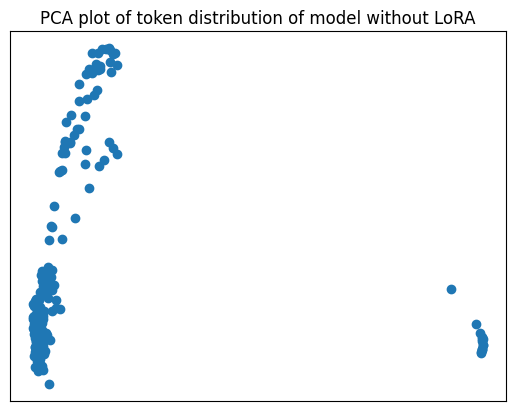

In [126]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_tsne = pca.fit_transform(model_nolora_artifacts.last_hidden_state.squeeze().detach().cpu().numpy())
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
# plt.xticks(False)
# plt.yticks(False)
plt.xticks([], [])
plt.yticks([], [])

plt.title("PCA plot of token distribution of model without LoRA")

Text(0.5, 1.0, 'PCA plot of token distribution of model with LoRA')

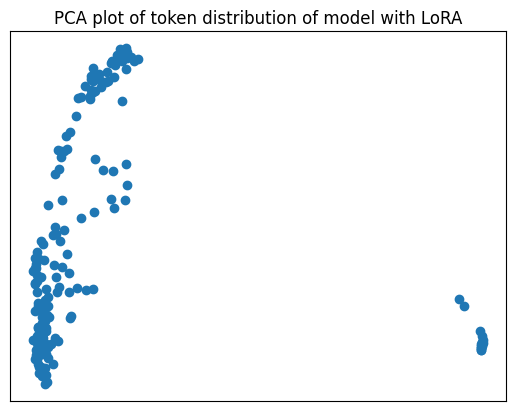

In [127]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_tsne = pca.fit_transform(model_lora_artifacts.last_hidden_state.squeeze().detach().cpu().numpy())
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
# plt.xticks(False)
# plt.yticks(False)
plt.xticks([], [])
plt.yticks([], [])

plt.title("PCA plot of token distribution of last layer with LoRA")

Text(0.5, 1.0, 't-SNE plot of token distribution of model without LoRA')

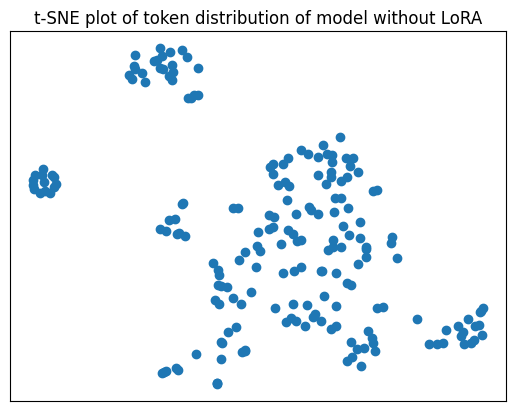

In [180]:
# model_nolora_artifacts.last_hidden_state.shape

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_train_tsne = tsne.fit_transform(model_nolora_artifacts.last_hidden_state.squeeze().detach().cpu().numpy())
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
# plt.xticks(False)
# plt.yticks(False)
plt.xticks([], [])
plt.yticks([], [])

plt.title("t-SNE plot of token distribution of model without LoRA")

Text(0.5, 1.0, 't-SNE plot of token distribution of model with LoRA')

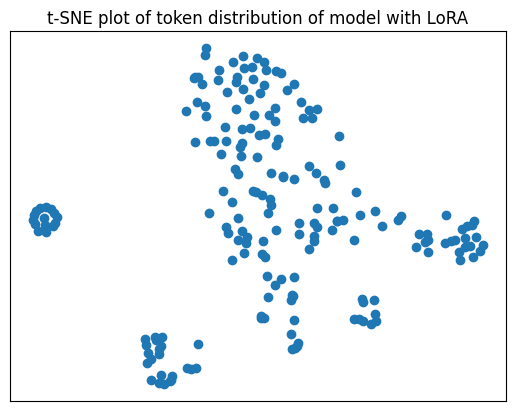

In [181]:
# model_nolora_artifacts.last_hidden_state.shape

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_train_tsne = tsne.fit_transform(model_lora_artifacts.last_hidden_state.squeeze().detach().cpu().numpy())
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
# plt.xticks(False)
# plt.yticks(False)
plt.xticks([], [])
plt.yticks([], [])

plt.title("t-SNE plot of token distribution of model with LoRA")

In [ ]:
def visualize_token_distribution(model_arts):
    

In [122]:
lorafeats.shape

torch.Size([3669, 768])

Text(0.5, 1.0, 't-SNE plot of model features with LoRA')

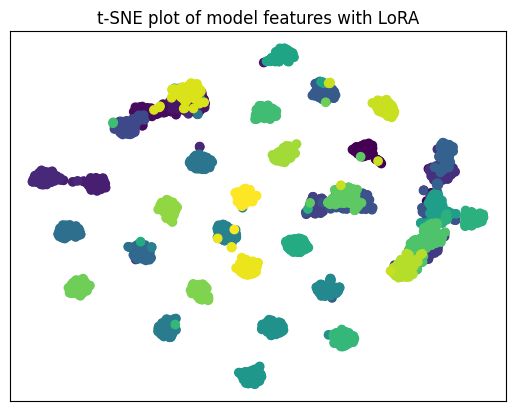

In [179]:
with torch.no_grad():
    lorafeats, labs = model_call_dl(model_lora, load_dataset())

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=40, random_state=42)
X_train_tsne = tsne.fit_transform(lorafeats.detach().cpu().numpy())
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labs.numpy())
# plt.xticks(False)
# plt.yticks(False)
plt.xticks([], [])
plt.yticks([], [])

plt.title("t-SNE plot of model features with LoRA")

In [177]:
with torch.no_grad():
    nolorafeats, labs = model_call_dl(model_nolora, load_dataset())

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=40, random_state=42)
X_train_tsne = tsne.fit_transform(nolorafeats.detach().cpu().numpy())


# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labs.numpy())
# plt.xticks(False)
# plt.yticks(False)
# plt.title("t-SNE of model without LoRA")

Text(0.5, 1.0, 't-SNE plot of model features without LoRA')

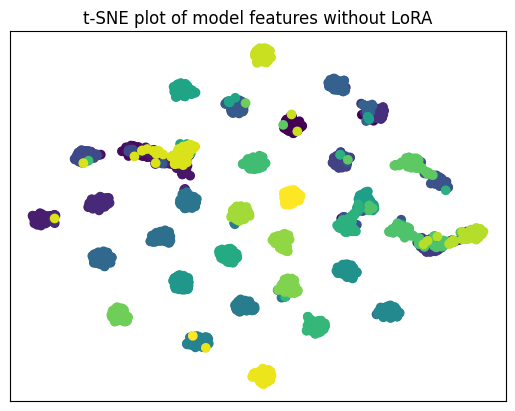

In [178]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labs.numpy())
# plt.xticks(False)
# plt.yticks(False)
plt.xticks([], [])
plt.yticks([], [])

plt.title("t-SNE plot of model features without LoRA")

In [42]:
torch.nn.functional.cosine_similarity(lorafeats, nolorafeats)

tensor(0.8047, device='cuda:0')

In [55]:
from collections import defaultdict
lora_bucketed = defaultdict(lambda: list())
nolora_bucketed = defaultdict(lambda: list())

for i in range(len(lorafeats)):
    lora_bucketed[labs[i].item()].append(lorafeats[i])
    nolora_bucketed[labs[i].item()].append(nolorafeats[i])


In [71]:
lorafeats_buck = list()
nolorafeats_buck = list()
for i in range(37):
    lorafeats_buck.append(torch.stack(lora_bucketed[i], dim=0))
    nolorafeats_buck.append(torch.stack(nolora_bucketed[i], dim=0))

In [76]:
classwise_cs = list()
for i in range(37):
    classwise_cs.append(torch.nn.functional.cosine_similarity(nolorafeats_buck[i], lorafeats_buck[i]).mean().item())

In [160]:
classwise_cs

[0.8335029482841492,
 0.7436452507972717,
 0.8093463182449341,
 0.823333740234375,
 0.8510717749595642,
 0.72419673204422,
 0.7316474914550781,
 0.6993346214294434,
 0.8505377173423767,
 0.639159619808197,
 0.8553453683853149,
 0.7445369958877563,
 0.8163671493530273,
 0.8554859757423401,
 0.8607031106948853,
 0.8649479746818542,
 0.8065993785858154,
 0.8127162456512451,
 0.894795298576355,
 0.8594238758087158,
 0.660233736038208,
 0.8511647582054138,
 0.807513415813446,
 0.7998839616775513,
 0.847533106803894,
 0.8759509921073914,
 0.6983292698860168,
 0.6896805167198181,
 0.8795414566993713,
 0.8716497421264648,
 0.8457207083702087,
 0.7585800290107727,
 0.8357059955596924,
 0.7911796569824219,
 0.8286142945289612,
 0.8613864183425903,
 0.7844221591949463]

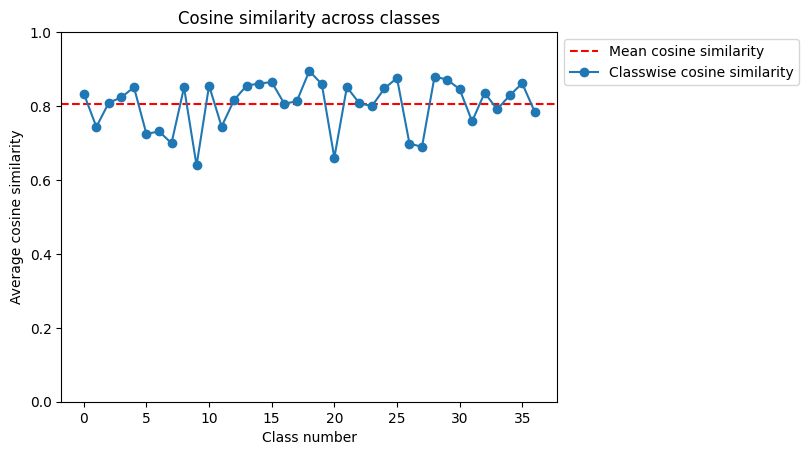

In [175]:
plt.clf()

plt.ylim((0, 1))
plt.xlabel("Class number")
plt.ylabel("Average cosine similarity")
# plt.yticks([np.mean(classwise_cs)], [str(round(np.mean(classwise_cs), 3))])
# plt.xticklabels([str(np.mean(classwise_cs))])
plt.title("Cosine similarity across classes")
plt.axhline(y = np.mean(classwise_cs), linestyle = "--", color="r", label="Mean cosine similarity")
plt.plot(classwise_cs,  "o-", label="Classwise cosine similarity")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'best') 


In [128]:
from glob import glob

Images:  ['/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer0.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer01.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer02.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer03.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer04.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer05.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer06.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer07.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer08.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer09.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer10.jpg', '/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer11.jpg']
Images count:  12
0 0
1 / 12 :  /workspace/akane/TA_for_CL/viz/lora_attn_maps_layer0.jpg
1 0
2 / 12 :  /workspace/akane/TA_for_CL/viz/lora_attn_maps_layer01.jpg
2 0
3 / 12 :  /workspace/akane/TA_for_CL/viz/lora_attn_maps_layer02.jpg
3 0
4 / 12 :  /workspace/a

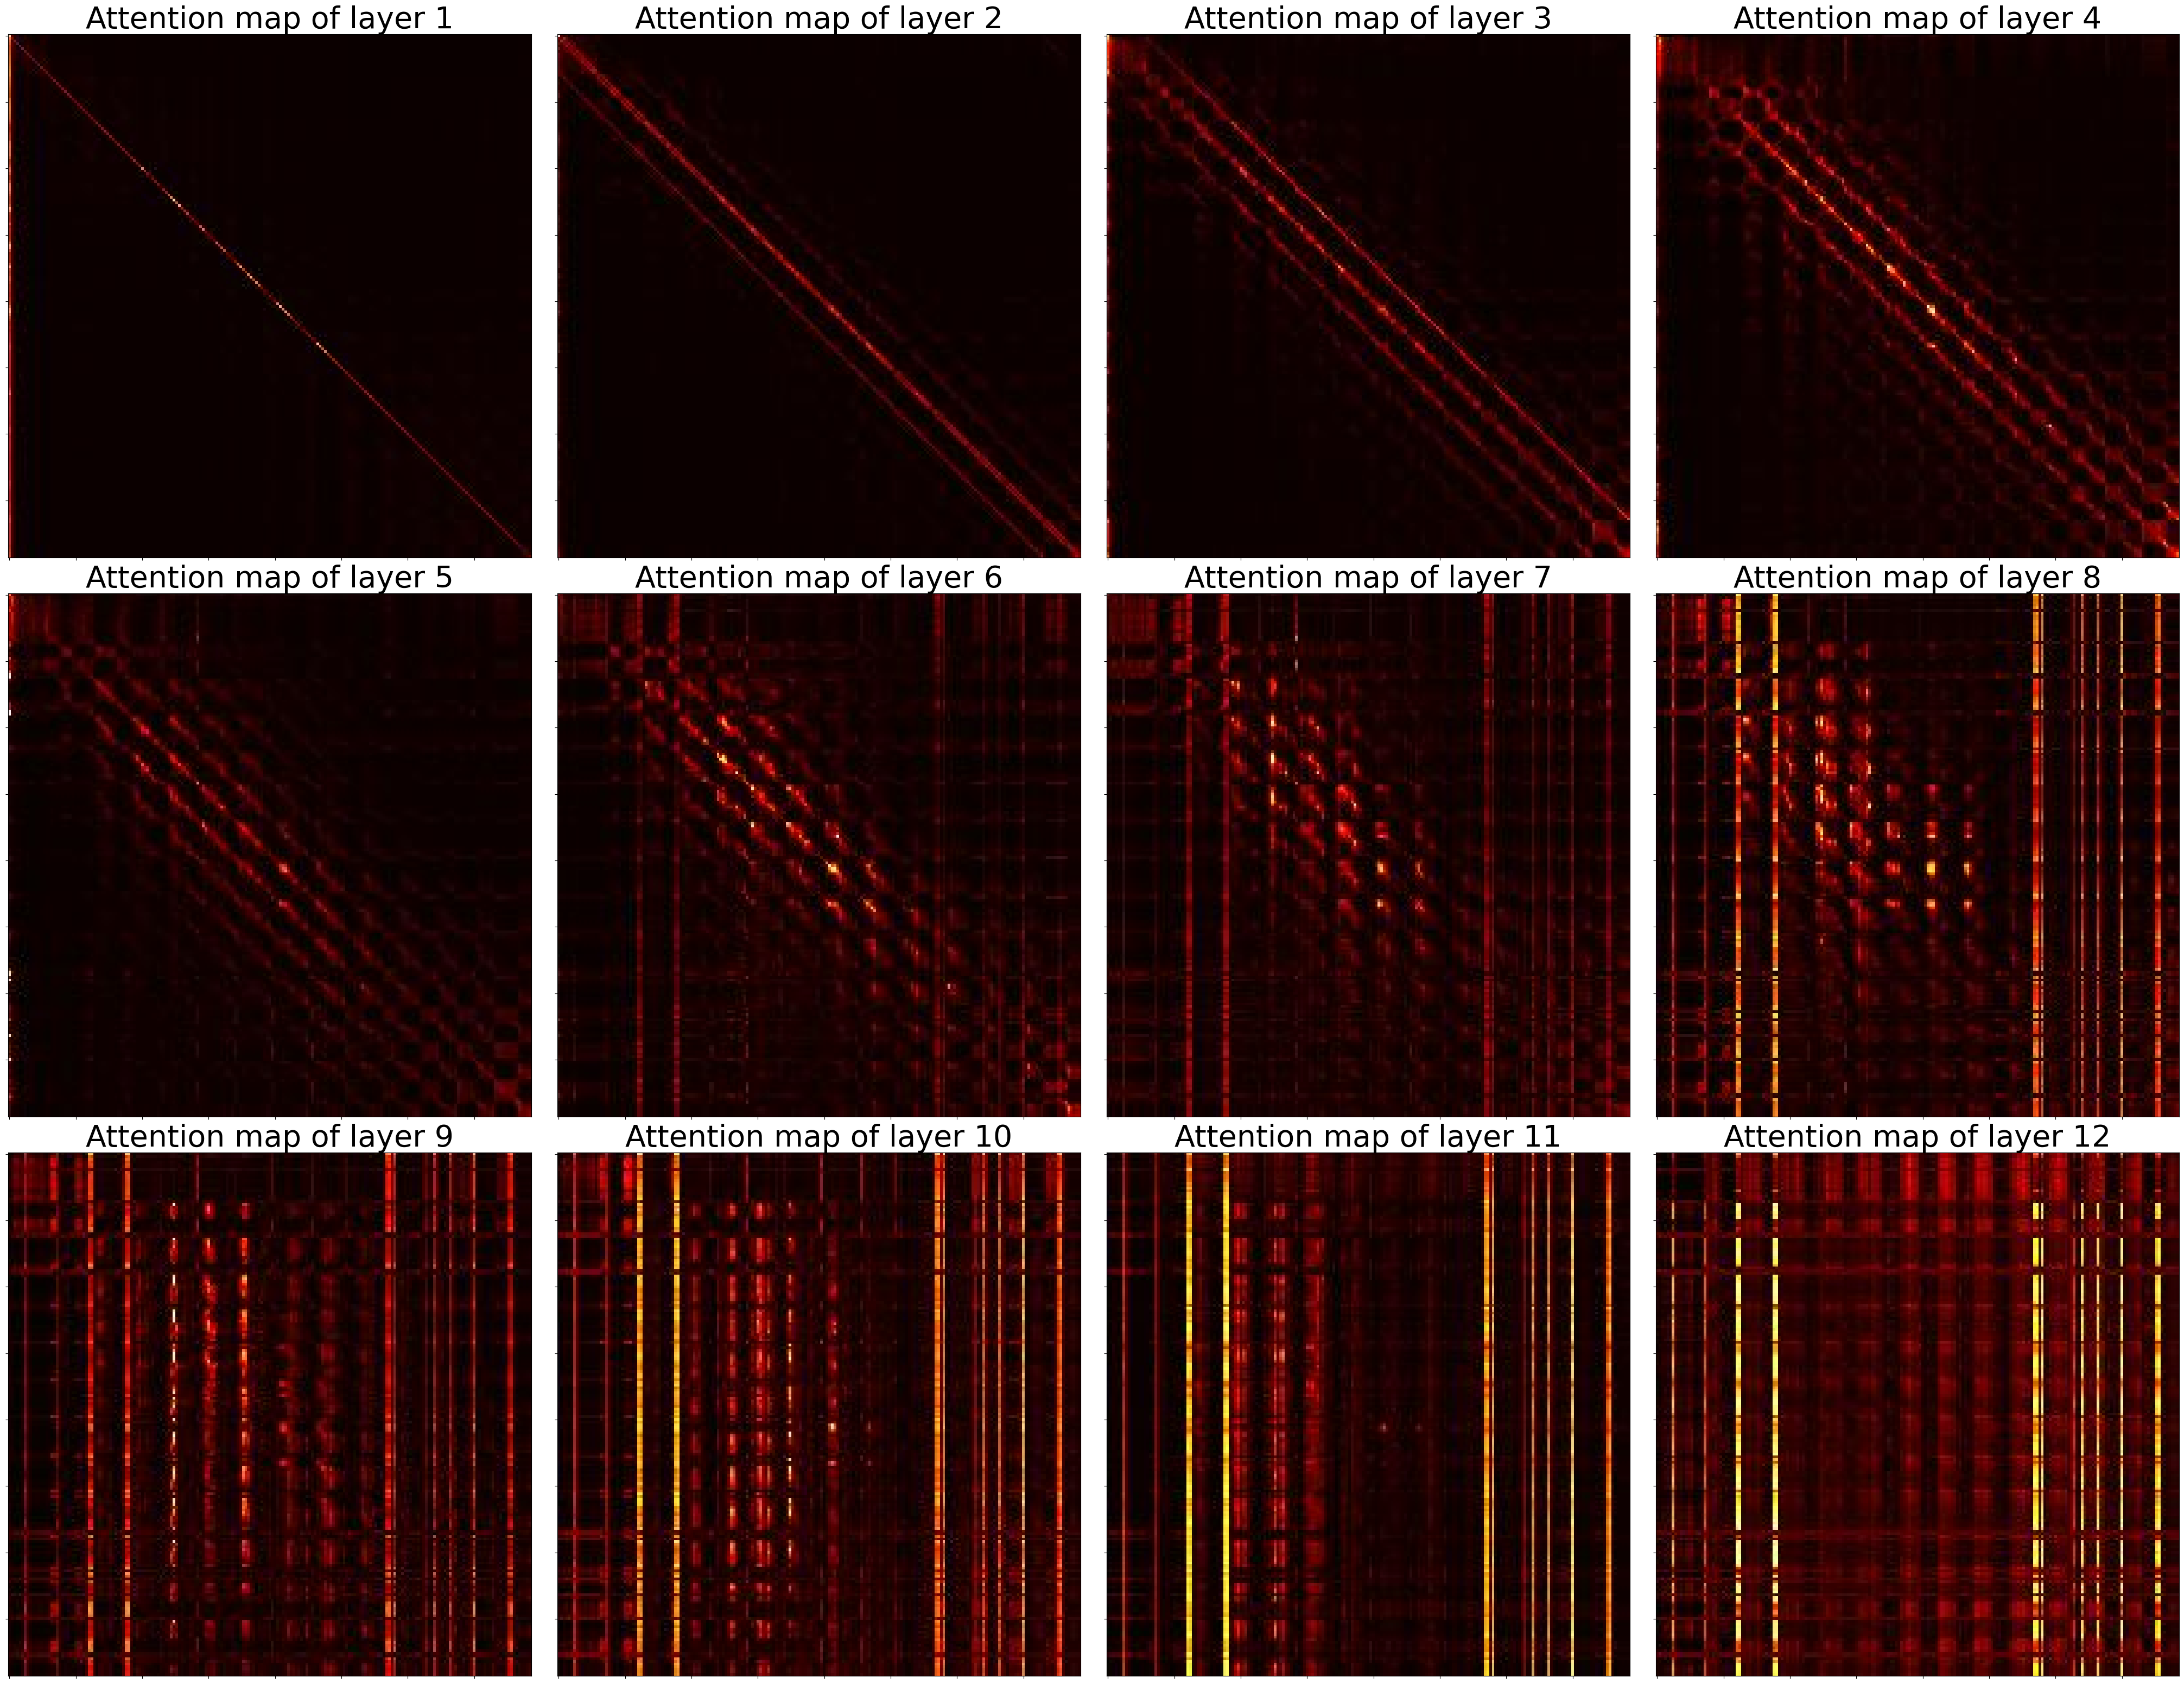

In [155]:
result_grid_filename = './grid.jpg'
result_figsize_resolution = 40 # 1 = 100px

images_list = glob("/workspace/akane/TA_for_CL/viz/lora_attn_maps_layer*.jpg")

images_list.sort()
images_count = len(images_list)
print('Images: ', images_list)
print('Images count: ', images_count)

# Calculate the grid size:
# grid_size = math.ceil(math.sqrt(images_count))

# Create plt plot:
fig, axes = plt.subplots(3, 4, figsize=(result_figsize_resolution, result_figsize_resolution))

current_file_number = 0
for image_filename in images_list:
    x_position = current_file_number % 4
    y_position = current_file_number // 4
    print(x_position, y_position)

    plt_image = plt.imread(images_list[current_file_number])
    axes[y_position, x_position].imshow(plt_image)
    print((current_file_number + 1), '/', images_count, ': ', image_filename)
    axes[y_position, x_position].set_xticklabels([])
    axes[y_position, x_position].set_yticklabels([])
    axes[y_position, x_position].set_title(f"Attention map of layer {current_file_number + 1}", {'fontsize':40})

    current_file_number += 1

plt.subplots_adjust(left=0.0, right=1)
plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.savefig("all_attn_lora.jpg")

Images:  ['/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer0.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer1.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer2.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer3.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer4.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer5.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer6.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer7.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer8.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer9.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer910.jpg', '/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer911.jpg']
Images count:  12
0 0
1 / 12 :  /workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer0.jpg
1 0
2 / 12 :  /workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer1.jpg
2 0
3 / 12 :  /workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer2.jpg
3 0
4

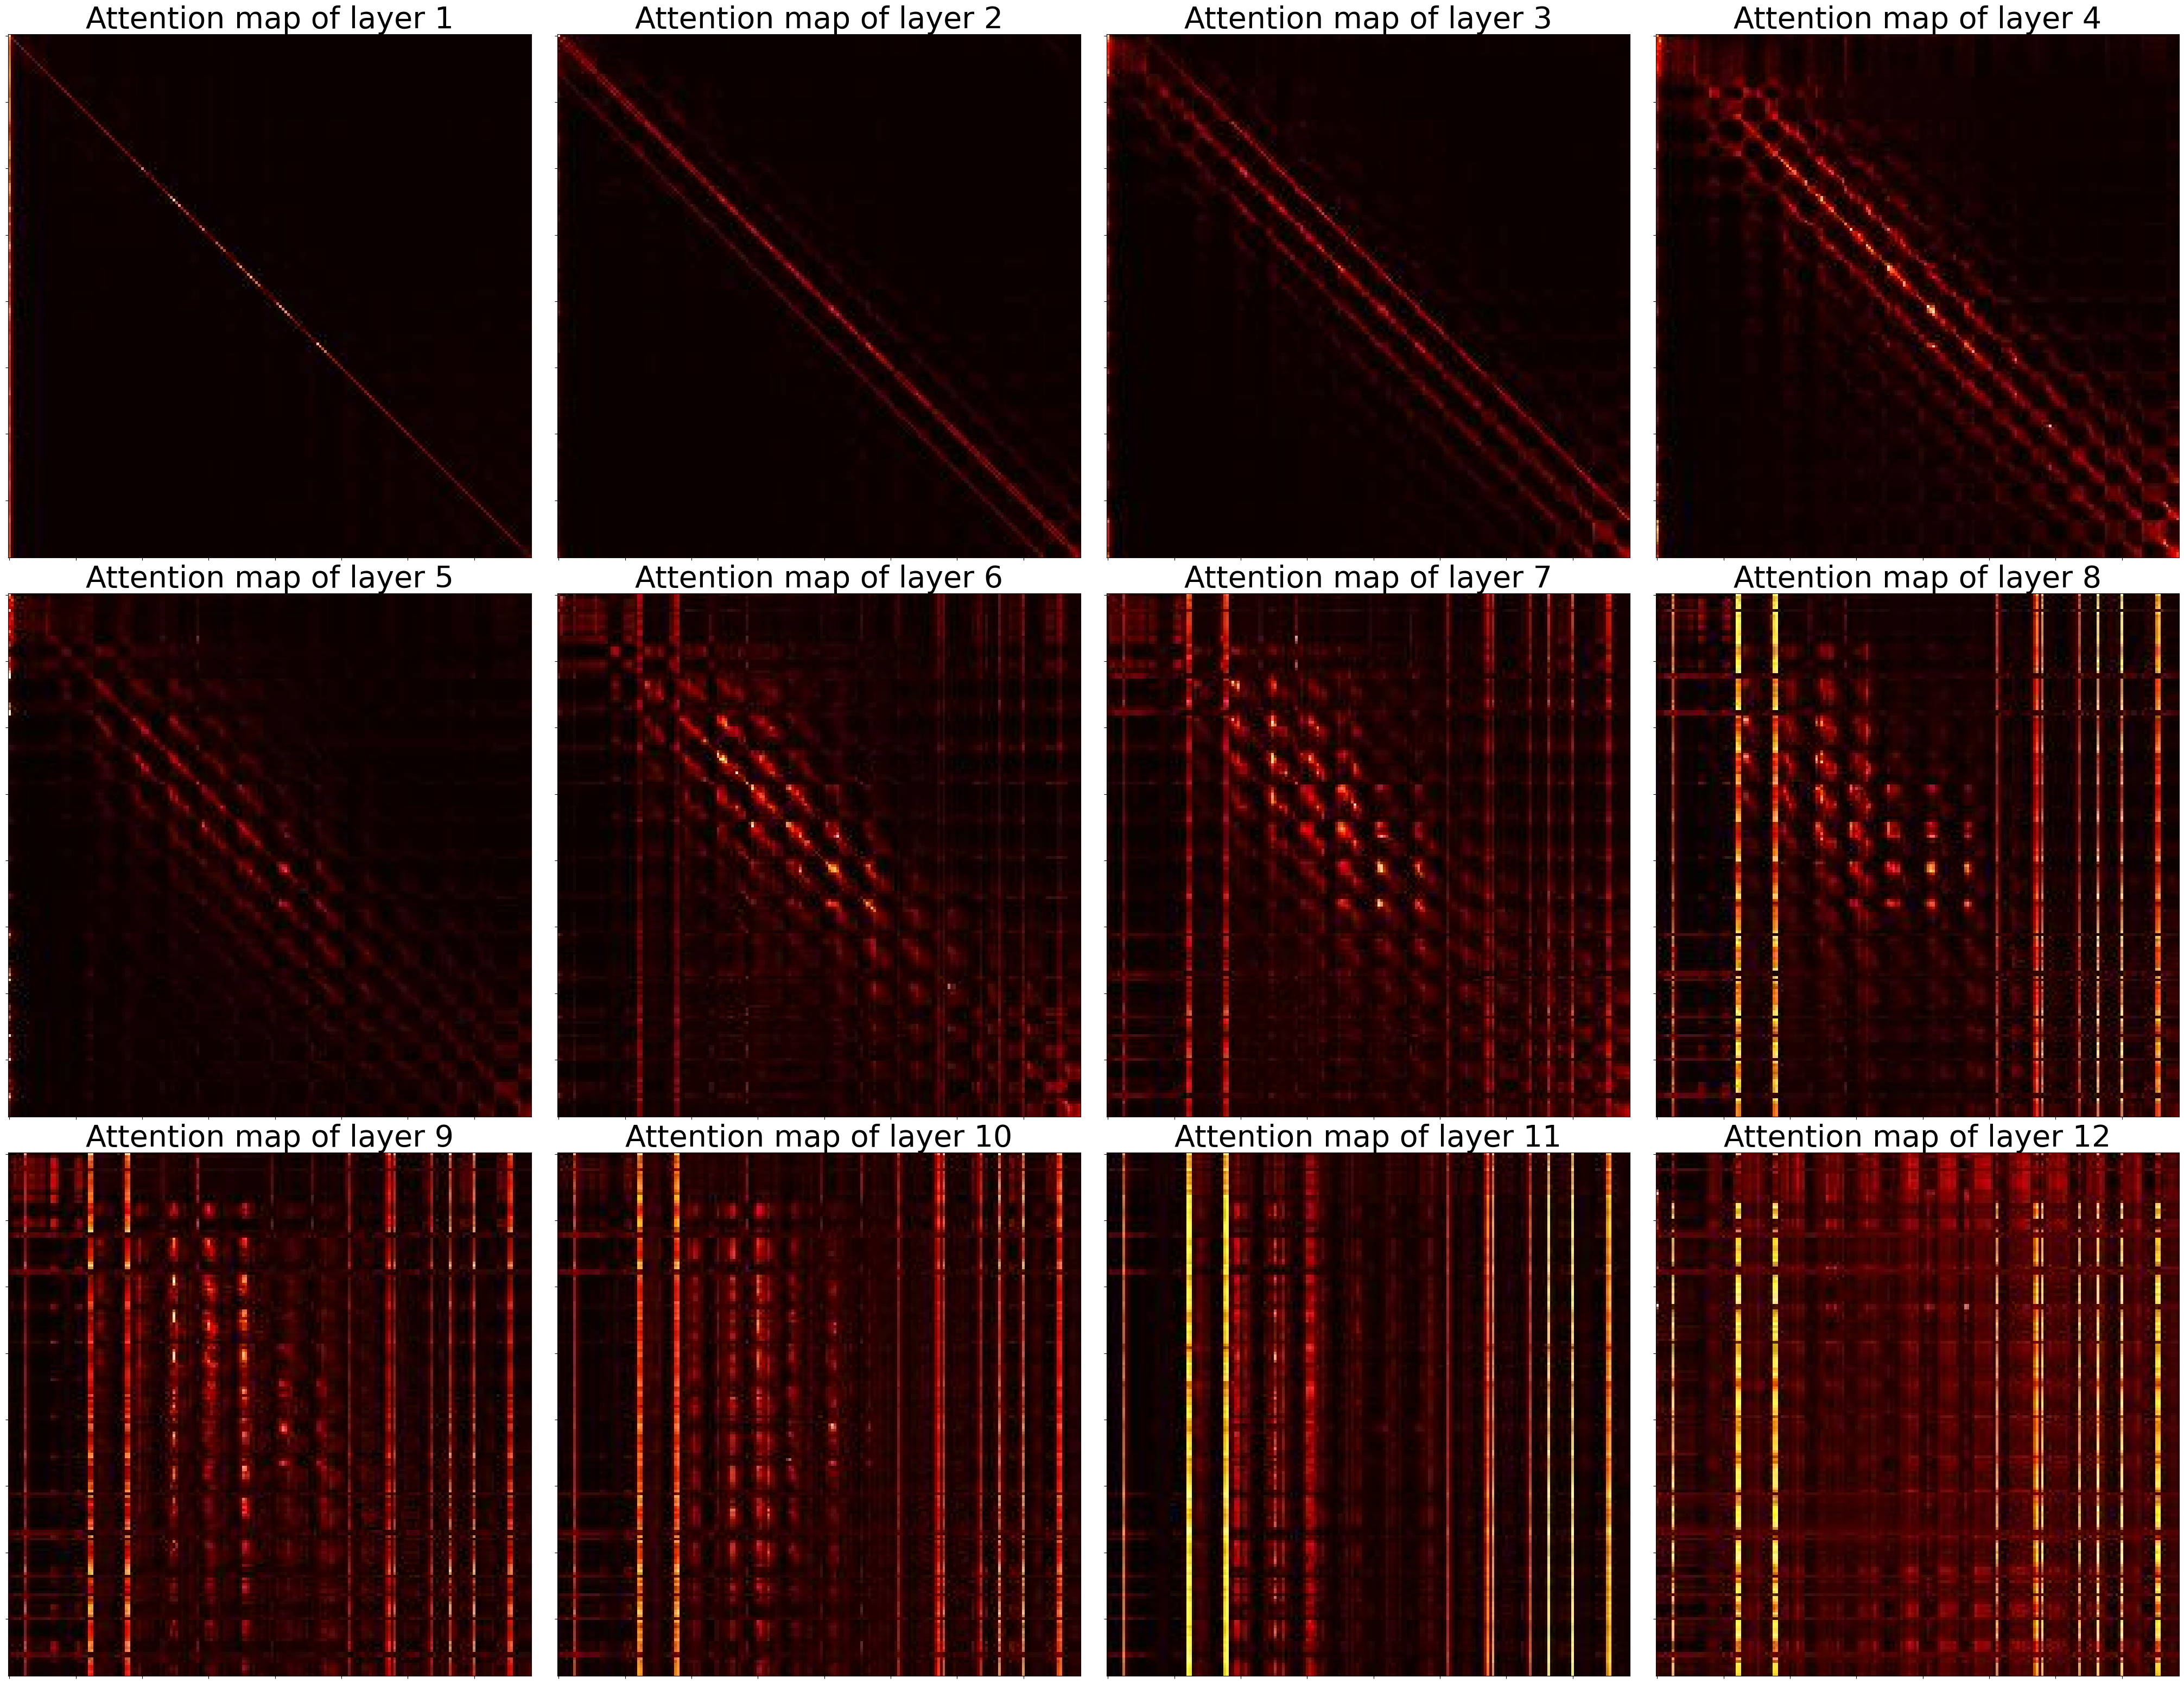

In [157]:
result_grid_filename = './grid.jpg'
result_figsize_resolution = 40 # 1 = 100px

images_list = glob("/workspace/akane/TA_for_CL/viz/nolora_attn_maps_layer*.jpg")

images_list.sort()
images_count = len(images_list)
print('Images: ', images_list)
print('Images count: ', images_count)

# Calculate the grid size:
# grid_size = math.ceil(math.sqrt(images_count))

# Create plt plot:
fig, axes = plt.subplots(3, 4, figsize=(result_figsize_resolution, result_figsize_resolution))

current_file_number = 0
for image_filename in images_list:
    x_position = current_file_number % 4
    y_position = current_file_number // 4
    print(x_position, y_position)

    plt_image = plt.imread(images_list[current_file_number])
    axes[y_position, x_position].imshow(plt_image)
    print((current_file_number + 1), '/', images_count, ': ', image_filename)
    axes[y_position, x_position].set_xticklabels([])
    axes[y_position, x_position].set_yticklabels([])
    axes[y_position, x_position].set_title(f"Attention map of layer {current_file_number + 1}", {'fontsize':40})

    current_file_number += 1

plt.subplots_adjust(left=0.0, right=1)
plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.savefig("all_attn_nolora.jpg")